In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier

import gseapy as gp

from tqdm import tqdm

In [2]:
df = pd.read_csv('attention.csv.gz', index_col=0, low_memory=False)
tmp = np.load('../../Drug_Response_Prediction_using_GNN/exp/idxs.npy', allow_pickle=True)[1]
df.index = tmp
df.columns = tmp
drug = df[:269]
drug_gene = drug.iloc[:, 329:]

In [3]:
drug_gene

,A2M,AAK1,ABCB1,ABL1,ABL2,ABRACL,ACAT1,ACKR3,ACLY,ACO2,...,ZNF207,ZNF22,ZNF580,ZNF593,ZNF706,ZNHIT1,ZNHIT3,ZNRD1,ZWINT,ZYX
740,0.003684,0.000000,0.003669,0.000000,0.000000,0.003496,0.003454,0.003605,0.003355,0.003446,...,0.003412,0.003558,0.003408,0.003410,0.003498,0.003412,0.003494,0.003540,0.003394,0.003387
752,0.003608,0.004824,0.003581,0.004963,0.004949,0.003423,0.003373,0.003529,0.003250,0.003382,...,0.003327,0.003505,0.003340,0.003308,0.003361,0.003338,0.003412,0.003434,0.003295,0.003294
755,0.003530,0.000000,0.003582,0.000000,0.000000,0.003360,0.003335,0.003479,0.003221,0.003301,...,0.003307,0.003430,0.003286,0.003286,0.003371,0.003272,0.003372,0.003386,0.003289,0.003258
762,0.003530,0.004777,0.003577,0.004939,0.004880,0.003393,0.003360,0.003474,0.003244,0.003318,...,0.003330,0.003448,0.003285,0.003300,0.003380,0.003285,0.003378,0.003418,0.003271,0.003272
1390,0.003637,0.000000,0.003649,0.000000,0.000000,0.003456,0.003425,0.003601,0.003295,0.003382,...,0.003382,0.003535,0.003351,0.003374,0.003419,0.003370,0.003442,0.003498,0.003341,0.003323
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
772992,0.003556,0.000000,0.003533,0.000000,0.000000,0.003360,0.003360,0.003477,0.003229,0.003312,...,0.003313,0.003437,0.003282,0.003307,0.003352,0.003297,0.003363,0.003401,0.003251,0.003257
783107,0.003630,0.004834,0.003642,0.004972,0.004920,0.003450,0.003415,0.003566,0.003282,0.003380,...,0.003364,0.003489,0.003333,0.003337,0.003427,0.003352,0.003422,0.003481,0.003323,0.003296
784722,0.003471,0.000000,0.003424,0.000000,0.000000,0.003279,0.003245,0.003355,0.003149,0.003245,...,0.003215,0.003329,0.003229,0.003203,0.003280,0.003220,0.003269,0.003314,0.003185,0.003187
789797,0.003532,0.004745,0.003518,0.004916,0.004857,0.003357,0.003336,0.003449,0.003204,0.003296,...,0.003284,0.003394,0.003263,0.003237,0.003327,0.003261,0.003307,0.003368,0.003253,0.003222


In [4]:
human = gp.get_library_name(organism='Human')
human

['ARCHS4_Cell-lines',
 'ARCHS4_IDG_Coexp',
 'ARCHS4_Kinases_Coexp',
 'ARCHS4_TFs_Coexp',
 'ARCHS4_Tissues',
 'Achilles_fitness_decrease',
 'Achilles_fitness_increase',
 'Aging_Perturbations_from_GEO_down',
 'Aging_Perturbations_from_GEO_up',
 'Allen_Brain_Atlas_10x_scRNA_2021',
 'Allen_Brain_Atlas_down',
 'Allen_Brain_Atlas_up',
 'Azimuth_2023',
 'Azimuth_Cell_Types_2021',
 'BioCarta_2013',
 'BioCarta_2015',
 'BioCarta_2016',
 'BioPlanet_2019',
 'BioPlex_2017',
 'CCLE_Proteomics_2020',
 'CORUM',
 'COVID-19_Related_Gene_Sets',
 'COVID-19_Related_Gene_Sets_2021',
 'Cancer_Cell_Line_Encyclopedia',
 'CellMarker_Augmented_2021',
 'ChEA_2013',
 'ChEA_2015',
 'ChEA_2016',
 'ChEA_2022',
 'Chromosome_Location',
 'Chromosome_Location_hg19',
 'ClinVar_2019',
 'DSigDB',
 'Data_Acquisition_Method_Most_Popular_Genes',
 'DepMap_WG_CRISPR_Screens_Broad_CellLines_2019',
 'DepMap_WG_CRISPR_Screens_Sanger_CellLines_2019',
 'Descartes_Cell_Types_and_Tissue_2021',
 'Diabetes_Perturbations_GEO_2022',
 'DisG

In [5]:
def pad_dict(dictionary, pad_value):
    max_length = max(len(v) for v in dictionary.values())
    for key in dictionary:
        dictionary[key] += [pad_value] * (max_length - len(dictionary[key]))
    return dictionary

In [6]:
res = {}
for i in drug_gene.index:
    tmp = drug_gene.loc[i]
    tmp = tmp[tmp != 0]
    if len(tmp) > 0:
        res[i] = list(tmp.sort_values(ascending=False).index)
        
padded_dict = pad_dict(res, None)
res = pd.DataFrame(padded_dict).T

In [7]:
res.loc[740].dropna()[:100]

0        ATIC
1        TYMS
2        DHFR
3      MIR330
4     SNORD16
       ...   
95       HBE1
96       GPX2
97       TFF2
98       APOD
99      PHGR1
Name: 740, Length: 100, dtype: object

In [1]:
results = pd.DataFrame()
for i in res.index:
    while True:
        try:
            enr = gp.enrichr(gene_list=list(res.loc[i].dropna()[:100]), 
                             gene_sets='MSigDB_Hallmark_2020',
                             organism='human', 
                             outdir=None)
            tmp = enr.results
            tmp = tmp[tmp['Adjusted P-value'] < 0.05].sort_values(['Adjusted P-value'])[['Term', 'Adjusted P-value', 'Genes']]
            tmp['drug'] = len(tmp)*[i]
            results = pd.concat([results, tmp])
            break
        except Exception as e:
            print(f"Error: {e}")
            print("Retrying...")

In [ ]:
name = dict(pd.read_csv(
    'nsc_cid_smiles_class_name.csv', 
    index_col=0)[['NSC', 'NAME']].values)

In [ ]:
results['drug'] = [name[int(i)] for i in results['drug']]
results

In [ ]:
df = results.groupby('Term')['drug'].count().reset_index().merge(results.groupby('Term')['Adjusted P-value'].mean().reset_index())
df = df.sort_values('drug', ascending=False)
df = df[df['drug'] > 10]
df

In [ ]:
# df.to_csv('gea.csv')

In [3]:
df = pd.read_csv('gea.csv', index_col=0)

/var/folders/s4/6xgylm7x3yzgfsk6sbvk_7_c0000gn/T/ipykernel_79752/747699544.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap(cmap_name)
/var/folders/s4/6xgylm7x3yzgfsk6sbvk_7_c0000gn/T/ipykernel_79752/747699544.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


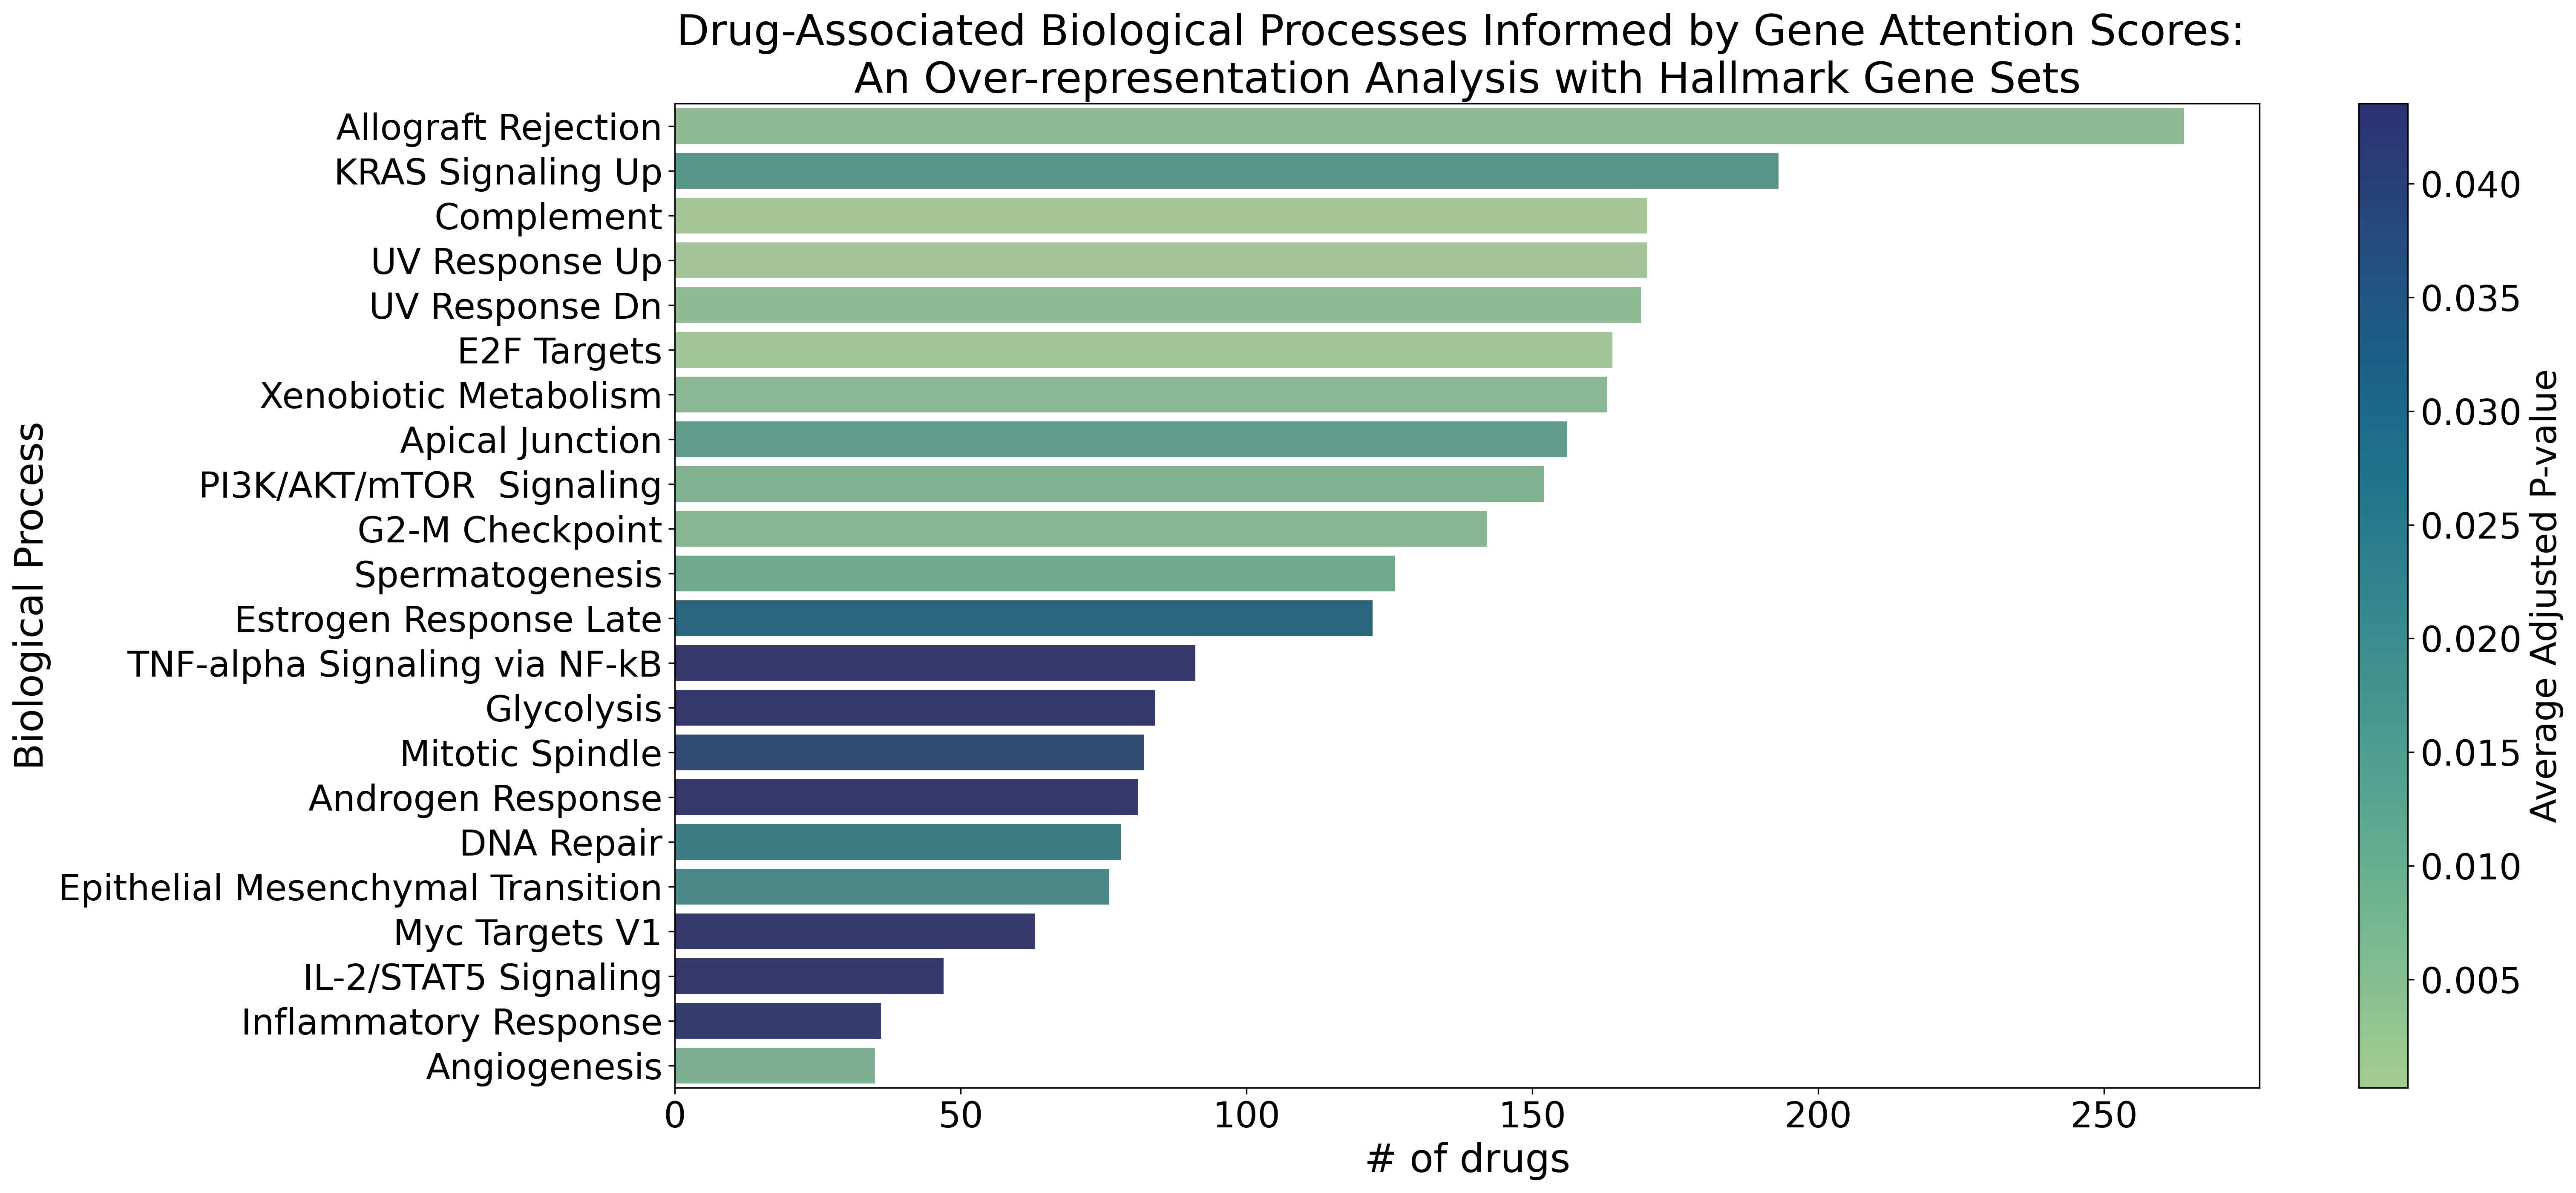

In [14]:
cmap_name = 'crest'
cmap = plt.cm.get_cmap(cmap_name)

# データを取得
data = list(df['Adjusted P-value'])

# カラーマップの上限と下限を設定
vmin = np.min(data)
vmax = np.max(data)

# 正規化オブジェクトの作成
norm = plt.Normalize(vmin=vmin, vmax=vmax)

# カラーマップに基づいて色を割り当てる
colors = [cmap(norm(value)) for value in data]

# 図と軸の生成
fig, ax = plt.subplots(figsize=[20, 10], dpi=300)
plt.rcParams.update({'font.size': 20})

# プロットを作成
sns.barplot(
    x='drug', y='Term', 
    data=df.assign(color=colors),  # ここで色の情報をデータフレームに追加
    palette=colors,  # そして、割り当てた色を利用
    dodge=False
)

plt.ylabel('Biological Process', fontsize=22)
plt.xlabel('# of drugs', fontsize=22)
plt.title('Drug-Associated Biological Processes Informed by Gene Attention Scores: \nAn Over-representation Analysis with Hallmark Gene Sets')

# カラーバーを表示
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)  # axを指定しています
cbar.set_label('Average Adjusted P-value')

# グラフを表示
plt.show()